# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.model_selection import cross_validate

from sklearn.metrics import precision_recall_fscore_support
import HelperFunctions as hf




%load_ext autoreload
#%reload_ext autoreload
%autoreload 2
%load_ext autotime

time: 476 µs (started: 2021-01-06 01:50:08 -05:00)


# Accessing helper functions and importing stopwords

In [7]:

from nltk.stem.snowball import SnowballStemmer
porter = SnowballStemmer("english", ignore_stopwords=True)


all_stopwords = hf.return_stopwords(lists=[],append=True)

def tok_p(text):
    return hf.tokenizer_porter(text,porter)

time: 3.98 ms (started: 2021-01-06 01:51:14 -05:00)


# Load Data

In [2]:
#15235 comments #10k + 3k query + 2k neutral
filename = '18kfinalfbdata_notclean.csv'
Tweets,Labels,brand=hf.load_data(filename,1,True)

print('Number of Comments:',np.size(Tweets))
print('Number of labels:',np.size(Labels))
print('Number of brand names:',np.size(brand))



Number of Comments: 18235
Number of labels: 18235
Number of brand names: 18235
time: 142 ms (started: 2021-01-06 01:50:08 -05:00)


# Store Data

In [4]:
#hf.store_data('18kfinalfbdata_notclean.csv', Tweets, Labels,brand)

time: 458 µs (started: 2021-01-05 02:38:14 -05:00)


# Sanity check (unique labels and sizes of extracted data)

In [5]:
ul =np.unique(Labels,return_counts=False)
print('Number of unique Labels:\t', ul)


Number of unique Labels:	 ['Negative' 'Neutral' 'Positive' 'Query' 'Very Negative' 'Very Positive']
time: 5.85 ms (started: 2021-01-05 02:38:15 -05:00)


# Data Cleaning

In [6]:
Tweets_cleaned = hf.clean_data(Tweets,all_stopwords)

time: 2.2 s (started: 2021-01-05 02:38:16 -05:00)


# Extracting 10 Most common words per category

In [7]:
#tokens = hf.category_tokenization(Tweets, Labels,all_stopwords,porter,stop_words=True,tokenize_porter=True)
#c,c_vp,c_p,c_ne,c_n,c_vn,c_q=hf.most_common(tokens)

time: 671 µs (started: 2021-01-05 02:38:19 -05:00)


# Filtering Data

In [3]:
for i in range(np.size(Labels)):
    if Labels[i]== 'Query':
        Labels[i]='Neutral'#append(Labelsf[i])


time: 5.79 ms (started: 2021-01-06 01:50:47 -05:00)


# Getting train and test data

In [4]:
X = Tweets#_cleaned#Tweets
y = Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

time: 12.9 ms (started: 2021-01-06 01:51:03 -05:00)


In [5]:
print('Train Data size',np.shape(X_train))
print('Train Labels size', np.shape(y_train))
print('Val Data size',np.shape(X_val))
print('Val Labels size',np.shape(y_val))
print('Test Data size',np.shape(X_test))
print('Test Labels size',np.shape(y_test))

Train Data size (16411,)
Train Labels size (16411,)
Val Data size (912,)
Val Labels size (912,)
Test Data size (912,)
Test Labels size (912,)
time: 27.6 ms (started: 2021-01-06 01:51:04 -05:00)


# Feature extraction

In [8]:
tfidf = TfidfVectorizer(tokenizer=tok_p, norm='l2',# analyzer='word', hf.tokenizer
                        ngram_range=(1,3))#, stop_words=all_stopwords)
features_train = tfidf.fit_transform(X_train)
features_val = tfidf.transform(X_val)
features_test = tfidf.transform(X_test)


time: 2.61 s (started: 2021-01-06 01:51:17 -05:00)


In [9]:
val=np.shape(y_val)[0]
test=np.shape(y_test)[0]

time: 1.42 ms (started: 2021-01-06 01:51:20 -05:00)


# 1 Linear SVM (Best)

In [10]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=0.58,penalty='l2', dual=True, max_iter=3000,class_weight='balanced')
out=svm.fit(features_train,y_train)
print(out.score(features_train,y_train))
print(out.score(features_test,y_test))

0.9932362439826945
0.743421052631579
time: 629 ms (started: 2021-01-06 01:51:22 -05:00)


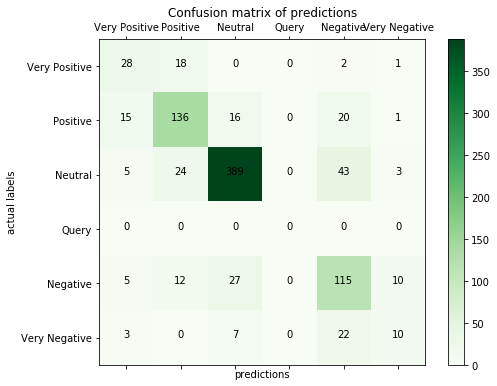

time: 327 ms (started: 2021-01-06 01:53:14 -05:00)


In [16]:
preds = svm.predict(features_test)
labels = ['Very Positive','Positive', 'Neutral','Query', 'Negative', 'Very Negative']
conf_mat=hf.plot_results(preds,labels,y_test)

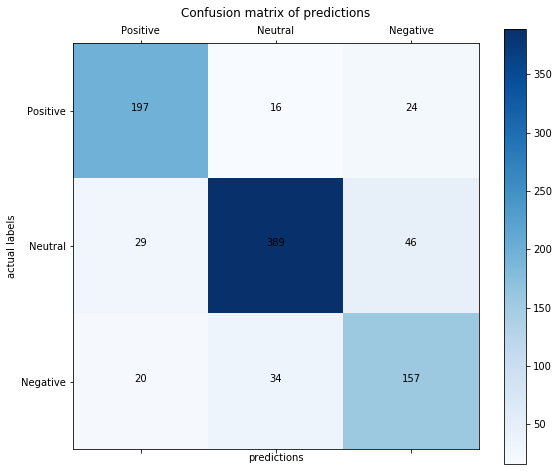

Accuracy :  81.46929824561403
Observed Agreement : 743
Random Chance Agreement : 339.797149122807
Kappa : 0.7046501957462791
time: 323 ms (started: 2021-01-06 01:53:17 -05:00)


In [17]:
new_conf_mat, acc=hf.category_reduction(conf_mat)

# Preprocessing for torch model

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
ytest = le.fit_transform(y_test)
ytrain = le.fit_transform(y_train)
yval = le.fit_transform(y_val)

#le = preprocessing.OneHotEncoder(handle_unknown='ignore')
#ytest = le.fit_transform(ytest.reshape(-1, 1))
#ytrain = le.fit_transform(ytrain.reshape(-1, 1))
#yval = le.fit_transform(yval.reshape(-1, 1))

time: 5.57 ms (started: 2021-01-05 02:38:38 -05:00)


In [18]:
#for i in range(10):
#    print(y_test[i],ytest[i])

# Negative = index(0)
# Neutral = index(1)
# Positive = index(2)
# Query = index(3)
# Very Negtaive = index(4)
# Very Positive = index(5)

time: 415 µs (started: 2021-01-05 02:38:50 -05:00)


In [19]:
print('Shape of training Features: ',np.shape(features_train))
print('Shape of validation Features: ',np.shape(features_val))
print('Shape of testing Features: ',np.shape(features_test))

print('Shape of training targets: ',np.shape(ytrain))
print('Shape of validation targets: ',np.shape(yval))
print('Shape of testing targets: ',np.shape(ytest))



Shape of training Features:  (16411, 201509)
Shape of validation Features:  (912, 201509)
Shape of testing Features:  (912, 201509)
Shape of training targets:  (16411,)
Shape of validation targets:  (912,)
Shape of testing targets:  (912,)
time: 1.25 ms (started: 2021-01-05 02:38:52 -05:00)


# Torch Model

In [20]:
import torch
import torch.nn as nn

time: 310 ms (started: 2021-01-05 02:38:55 -05:00)


In [34]:
import torch.optim as optim

class NN_SA(nn.Module):
    def __init__(self, config):
        super(NN_SA, self).__init__()
        self.inputSize = config["input_dim"]
        self.outputSize = config["output_dim"]
        self.hiddenSize1 = config["hidden1"] 
        self.hiddenSize2 = config["hidden2"] 
        self.alpha = config["learning_rate"]
        self.output_dim = config["classes"]
        self.N = config["N"]
        
        self.h1 = nn.Linear(self.inputSize, self.hiddenSize1)
        self.d1 = nn.Dropout(p=0.2)
        self.h2 = nn.Linear(self.hiddenSize1,self.hiddenSize2)
        self.d2 = nn.Dropout(p=0.5)
        self.h3 = nn.Linear(self.hiddenSize2,self.output_dim)
    def forward(self,x):
        x = torch.sigmoid(self.h1(x))
        #x = self.d1(x)
        #x = torch.sigmoid(self.h2(x))
        #x = self.d2(x)
        x = torch.relu(self.h3(x))
        #print(x)
        return x

time: 2.13 ms (started: 2021-01-05 02:42:30 -05:00)


In [22]:
Xtrain = torch.tensor(features_train.toarray(), dtype=torch.float) # 15k x 4 tensor
y_train = torch.tensor(ytrain, dtype=torch.long) # 15k, tensor
Xval = torch.tensor(features_val.toarray(), dtype=torch.float) # 15k x 4 tensor
y_val = torch.tensor(yval, dtype=torch.long) # 15k, tensor
Xtest = torch.tensor(features_test.toarray(), dtype=torch.float) # 15k x 4 tensor
y_test = torch.tensor(ytest, dtype=torch.long) # 15k, tensor

time: 26.8 s (started: 2021-01-05 02:39:00 -05:00)


In [37]:
torch.save(Xtrain, 'tensordatatrain.pt')
torch.save(Xval, 'tensordataval.pt')
torch.save(Xtest, 'tensordatatest.pt')

torch.load('tensordatatest.pt')

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

time: 15.5 s (started: 2021-01-05 03:56:12 -05:00)


In [36]:
torch.load('tensordata.pt').size()

torch.Size([912, 201509])

time: 632 ms (started: 2021-01-05 03:55:49 -05:00)


In [31]:
config= {"input_dim":np.shape(features_train)[1],
         "output_dim":1,
         "classes":int(y_train.max().item()+1),
         "hidden1": 100,
         "hidden2": 100,
         "mu": 0,
         "sigma_2":1,
         "learning_rate":0.001,
         "N": np.shape(features_train)[0],
         "batch_size" : 200,
         "epochs": 100,
         "iters": 20
         
    }
lr = config["learning_rate"]


time: 863 µs (started: 2021-01-05 02:40:30 -05:00)


In [32]:
NN = NN_SA(config)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#optimizer = optim.SGD(NN.parameters(), lr=lr, momentum=0.9)

optimizer = optim.Adam(NN.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0, amsgrad=False)

time: 114 ms (started: 2021-01-05 02:40:31 -05:00)


In [33]:
epochs = config["epochs"]
batch_size = config["batch_size"]
iters = config["iters"]
loss_val = 50000.0
val_dim = np.size(y_val)
display_interval = 1
i=0
for i in range(epochs):
    i+=1

    running_loss =0.0
    permutation = torch.randperm(Xtrain.size()[0])

    for j in range(iters):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = Xtrain[indices], y_train[indices]

        # in case you wanted a semi-full example
        outputs = NN.forward(batch_x)
        #outputs = outputs.resize(batch_size,)
        #print(outputs[1:10])
        #print(batch_y[1:10])
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    
    if i % display_interval == 0:    # print every display_interval=100 mini-batches
        outval = NN.forward(Xval)
        #outval = outval.resize(val,)
        lossv = criterion(outval, y_val)
        loss_val = lossv.item()
        print('iter : ',int(i/display_interval),'\t train loss :'+"{:.3f}".format(running_loss/iters),
             '\t val loss :'+"{:.4f}".format(loss_val))
        running_loss = 0.0


iter :  1 	 train loss :1.792 	 val loss :1.7918
iter :  2 	 train loss :1.792 	 val loss :1.7918
iter :  3 	 train loss :1.792 	 val loss :1.7918
iter :  4 	 train loss :1.792 	 val loss :1.7918
iter :  5 	 train loss :1.792 	 val loss :1.7918
iter :  6 	 train loss :1.792 	 val loss :1.7918
iter :  7 	 train loss :1.792 	 val loss :1.7918
iter :  8 	 train loss :1.792 	 val loss :1.7918
iter :  9 	 train loss :1.792 	 val loss :1.7918
iter :  10 	 train loss :1.792 	 val loss :1.7918
iter :  11 	 train loss :1.792 	 val loss :1.7918
iter :  12 	 train loss :1.792 	 val loss :1.7918


KeyboardInterrupt: 

time: 1min 42s (started: 2021-01-05 02:40:32 -05:00)


In [ ]:
classes = ['Negative', 'Neutral','Positive', 'Query', 'Very Negative', 'Very Positve']

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    outputs = NN(X_test)
    _,predicted = torch.max(outputs, 1)

    correct = (predicted == y_test).sum().item()
total=y_test.size(0)
print(total)
print('Accuracy of the network: %d %%' % (
    100 * correct / total))



In [ ]:
for i in range(10):
    index= np.random.randint(total-1)
    print('Comment:',X_test[index],'\n prediction: ',classes[predicted[index].item()],'\t true label:',classes[y_test[index].item()])

In [ ]:
outputs = NN(X_test)
outputs = outputs.resize(test,)
loss = criterion(outputs, y_test)
print('Test loss : ', loss.item())


In [ ]:
#torch.save(NN.state_dict(), 'MPC_model_weights')

In [ ]:
#NN.load_state_dict(torch.load('MPC_model_weights'))

# Logistic Regression

In [ ]:
c=[0.5]
for i in range(np.size(c)):
    logreg = LogisticRegression(random_state=42,solver='newton-cg',
                                penalty='l2',class_weight='balanced',
                                multi_class='auto',C=c[i], max_iter=2000)
    Lr = logreg.fit(features_train,y_train)
    score =Lr.score(features_train,y_train)
    print('c: ',c[i],'Train Accuracy : ',score*100,'%')
    score =Lr.score(features_test,y_test)
    print('c: ',c[i],'Test Accuracy : ',score*100,'%')

In [ ]:
cv_results = cross_validate(logreg, features_train, y_train, cv=5,return_train_score=True)
print(sorted(cv_results.keys()))
print('test scores: \t ',cv_results['test_score'])
print('train scores: \t ',cv_results['train_score'])
print('score times: \t ',cv_results['score_time'])
print('fit time: \t ',cv_results['fit_time'])

# Plotting Results

In [ ]:
preds = Lr.predict(features_test)
labels = ['Very Positive','Positive', 'Neutral','Query', 'Negative', 'Very Negative']
conf_mat=hf.plot_results(preds,labels,y_test)

In [ ]:
new_conf_mat, acc=hf.category_reduction(conf_mat)

In [ ]:
cv_results = cross_validate(svm, features_train, y_train, cv=5,return_train_score=True)
print(sorted(cv_results.keys()))
print('test scores: \t ',cv_results['test_score'])
print('train scores: \t ',cv_results['train_score'])
print('score times: \t ',cv_results['score_time'])
print('fit time: \t ',cv_results['fit_time'])

In [ ]:
svm.classes_

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l2", max_iter=2000,tol=2e-2)
clf.fit(features_train,y_train)
print(clf.score(features_train,y_train))
print(clf.score(features_test,y_test))

In [ ]:
cv_results = cross_validate(clf, features_train, y_train, cv=5,return_train_score=True)
print(sorted(cv_results.keys()))
print('test scores: \t ',cv_results['test_score'])
print('train scores: \t ',cv_results['train_score'])
print('score times: \t ',cv_results['score_time'])
print('fit time: \t ',cv_results['fit_time'])

# Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(features_train,y_train)
print(clf.score(features_train,y_train))
print(clf.score(features_test,y_test))

# KNearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,weights='uniform')
clf.fit(features_train,y_train)
print(clf.score(features_train,y_train))
print(clf.score(features_test,y_test))

# Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.1)
clf.fit(features_train,y_train)
print(clf.score(features_train,y_train))
print(clf.score(features_test,y_test))

# Decision Tree Classifier

Rather random results... could be pro or a con

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_features="sqrt",splitter="random",class_weight="balanced")
clf.fit(features_train,y_train)
print(clf.score(features_train,y_train))
print(clf.score(features_test,y_test))


# Multi Layer Perceptron (Classic NN)

In [ ]:
t=[(7,7)]
a= [3e-3]
for i in range(int(np.size(a))):
    from sklearn.neural_network import MLPClassifier
    clf = MLPClassifier(solver='adam', alpha=3e-3,
                        hidden_layer_sizes=t[i], random_state=1,
                       learning_rate = 'constant', max_iter=500,
                        momentum=0.9)
    clf.fit(features_train,y_train)

    score =clf.score(features_train,y_train)
    print('hl_size: ',t[i],'Train Accuracy : ',score*100,'%')
    score =clf.score(features_test,y_test)
    print('hl_size: ',t[i],'Test Accuracy : ',score*100,'%')
plt.plot(clf.loss_curve_)

# Printing Predictions

In [ ]:
for i in range(np.size(preds)):
    if preds[i]!='Neutral':
        print(X_test[i],'->', preds[i],'-',y_test[i])

# Precision, Recall and F1.score

In [ ]:

x=precision_recall_fscore_support(y_test, preds, 
                                  average='weighted', warn_for='recall')
print('Precision :', x[0]*100, '%')
print('Recall :', x[1]*100, '%')
print('F1 Score :', x[2]*100, '%')



# Assessing Annotation Stats

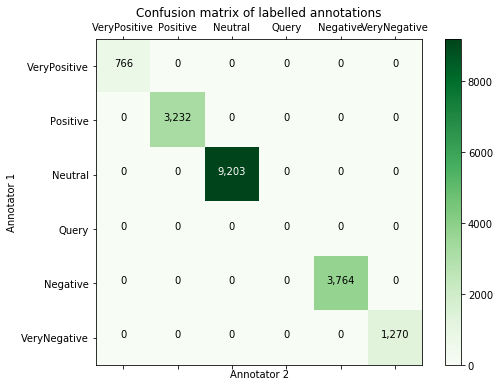

Observed Agreement : 18235
Random Chance Agreement : 6115.074581848095
Kappa : 1.0
time: 356 ms (started: 2021-01-06 01:53:45 -05:00)
